In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
#from astroquery.mast import Observations
import lightkurve
import celerite
from celerite import terms
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table

In [47]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True


Loading in the flare list from 2014

In [4]:
#2014 Flares List

flare_table=pd.read_csv('https://raw.githubusercontent.com/jradavenport/GJ1243-Flares/master/data/gj1243_master_flares.tbl',
            skiprows=23,delim_whitespace=True,names=['index of flare start in "gj1243_master_slc.dat"',
                                                   'index of flare stop in "gj1243_master_slc.dat"','t_start','t_stop'
                                                   ,'t_peak','t_rise','t_decay','flux peak',
                                                   'ED','Duration of rise',
                                                   'Duration of decay','Complex flag',
                                                   '# of people that identified flare event exists',
                                                   '# of people that analyzed this month',
                                                   '# of flare template components fit to event'])
t_starts=flare_table.loc[:,'t_start']
t_stops=flare_table.loc[:,'t_stop']
flux_peak = flare_table.loc[:,'flux peak'].values
complex_flag = flare_table['Complex flag'] #2=complex, 1 = classical
ED = flare_table['ED'] #units=seconds
flare_table['Flare_Duration'] = 1440.*(t_stops-t_starts) #units = minutes

In [5]:
# Separating the types of flares
classical = len([i for i in complex_flag if i < 2.0]) 
print ("The number of classical flares : " + str(classical)) 

cmplx = len([i for i in complex_flag if i > 1.0]) 
print ("The number of complex flares : " + str(cmplx)) 

complex_flares = flare_table[flare_table['Complex flag'] == 2.0]
classical_flares = flare_table[flare_table['Complex flag'] == 1.0]

#-----------------------------------------------------------------------------------------
min_dur = 20.0 #minutes
max_dur = 75.0

dur_limit = len([i for i in flare_table['Flare_Duration'] if i >= min_dur and i<max_dur]) 
print ("The number of total flares with a duration between 20-75min : " + str(dur_limit))

#------------------------------------------------------------------------------------------
#adding in a column that is the flare duration into the table 
classical_flares['Flare_Duration'] = 1440.*(classical_flares['t_stop'] - classical_flares['t_start'])
#classical_flares

print (len([i for i in classical_flares['Flare_Duration'] if i >= min_dur and i < max_dur]))

#------------------------------------------------------------------------------------------

#Table of Classical flares that are between 20-75 minutes as defined in Davenport(2014)

timed_classical = classical_flares[(classical_flares['Flare_Duration'] >= min_dur) & (classical_flares['Flare_Duration'] < max_dur)]
print(len(timed_classical))

The number of classical flares : 5162
The number of complex flares : 945
The number of total flares with a duration between 20-75min : 1641
902
902


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Importing in the final set of vetted classical flares from Kepler DR 25

In [6]:
kepler_flares =pd.read_csv('/Users/lupitatovar/local_flares/notebooks/flare_diagnostics/final_flare_diagnostics.csv',
            names=["Flare_Number","Type","Notes",'na','key'],skiprows=1)
flag = pd.to_numeric(kepler_flares["Type"].values, errors='coerce')

In [7]:
# FINAL SET OF VETTED KEPLER FLARES

k_classical = len([i for i in flag if i == 1.]) 
print ("The number of remaining classical flares : " + str(k_classical)) 

k_complex = len([i for i in flag if i == 3.]) 
print ("The number flares tossed out : " + str(k_complex)) 

k_edit = len([i for i in flag if i == 2.]) 
print ("The number of flares who need edited times : " + str(k_edit)) 


# Creating the data tables of newly classified flares (use these to make stacked flares plot)
final_edit_times = kepler_flares[kepler_flares["Type"].values == 2.]
final_toss = kepler_flares[kepler_flares["Type"].values == 3.]
final_classic_flares = kepler_flares[kepler_flares["Type"].values == 1.]

#includes flares that need start/stop times edited
keep_flares_final = final_edit_times.combine_first(final_classic_flares)

The number of remaining classical flares : 381
The number flares tossed out : 379
The number of flares who need edited times : 33


In [8]:
#adding index column to Jim's original timed_calssical flares list
timed_classical['Index'] = np.arange(len(timed_classical))
#timed_classical

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
#cross matching the two lists to get new table that has all the flare info!

final_kepler = pd.merge(left=timed_classical, right=keep_flares_final, left_on='Index', right_on='Flare_Number')

In [10]:
len(final_kepler)

414

In [11]:
#saving the 414 flares list table to a .csv that is now on github for public ref
#final_kepler.to_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/gj1243_kepler_classical_flares_list.csv')

Loading in the Kepler light curve for GJ 1243

In [12]:
from lightkurve import search_lightcurvefile
from lightkurve import search_targetpixelfile
target = '9726699'
gj1243_collection = search_lightcurvefile(target,cadence='short').download_all()

gj1243lc = gj1243_collection[0].PDCSAP_FLUX.remove_nans()

#stitching together the full light curve
for q in range(1,len(gj1243_collection)):
    try:
        gj1243lc = gj1243lc.append(gj1243_collection[q].PDCSAP_FLUX).remove_nans()
    except:
            print(q)

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  after removing the cwd from sys.path.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  # This is added back by InteractiveShellApp.init_path()
/Users/lupitatovar/anaco

0 (46806, 7)
1 (42289, 7)
2 (32946, 7)
3 (39984, 7)
4 (44060, 7)
5 (34037, 7)
6 (45254, 7)
7 (39630, 7)
8 (43978, 7)
9 (45006, 7)
10 (39121, 7)


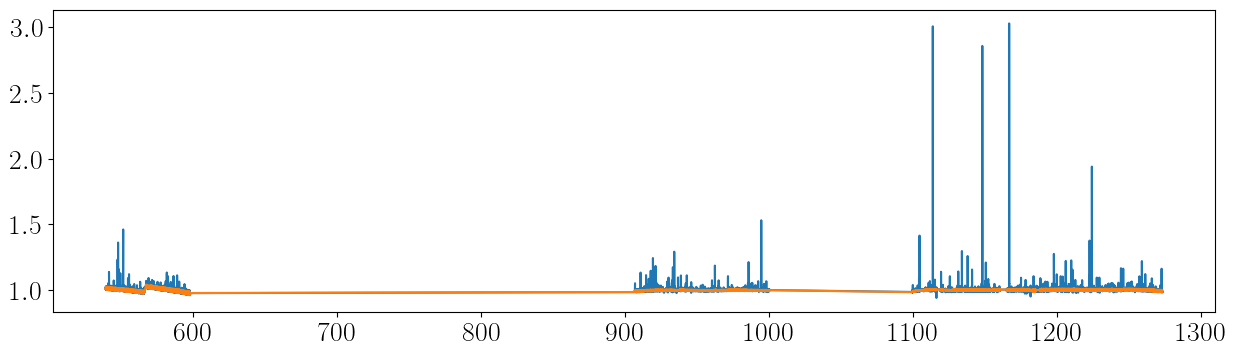

In [13]:
# Importing in GP Info
#Reading in the 11 mo gp files
from glob import glob

kepler_gp_files = glob('*11mo_*.csv')

for k in range(len(kepler_gp_files)): 
    df_tmp = pd.read_csv(kepler_gp_files[k]) 
    print(k, df_tmp.shape) 
    if k==0: 
        df = df_tmp 
    else: 
         df = df.append(df_tmp) 

df = df.sort_values(by='time')

plt.figure(figsize=(15,4))
plt.plot(df['time'], df['detrended_flux'])
plt.plot(df['time'], df['mean'])
plt.show()


Loading in the flare model to fit all of the flares

In [14]:
from scipy import special
def kepler_model(t,tpeak, fwhm, ampl, upsample=False, uptime=10):

    t_new = (t-tpeak)/fwhm +2


    #Values were fit & calculated using MCMC 256 walkers and 10000 steps

    A,B,C,D1,D2,f1 = [3.6281105426668883,1.7500017640073082,0.2035997267409103,1.3548846737678661,0.179091454739574,0.8107078443451485]
    #[18.012482847017512,1.972068713306366,0.044908682424470825,6.536339731685045,0.9387724469269554,0.6183448164959743]
    #[3.714766073353358,1.749665640328046,0.1979131664366433,0.17912992867648345,1.3591276162814818,0.19600454472080225]
    z1 = ((2*B + (C**2 *D1))/(2*C))
    z2 = ((2*B + C**2 *D2)/(2*C))
    f2 = 1-f1
    
    if upsample:
        dt = np.nanmedian(np.diff(np.abs(t_new)))
        timeup = np.linspace(min(t_new)-dt, max(t_new)+dt, t_new.size * uptime)

        flareup = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-timeup)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (timeup/C))))
                                                 + (f2 * np.exp((D2*(B-timeup)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (timeup/C)))))

        # and now downsample back to the original time...
        ## this way might be better, but makes assumption of uniform time bins
        # flare = np.nanmean(flareup.reshape(-1, uptime), axis=1)

        ## This way does linear interp. back to any input time grid
        # flare = np.interp(t, timeup, flareup)

        ## this was uses "binned statistic"
        downbins = np.concatenate((t_new-dt/2.,[max(t_new)+dt/2.]))
        flare,_,_ = binned_statistic(timeup, flareup, statistic='mean',bins=downbins)
    else:
        flare = (1/2) * np.sqrt(np.pi) * A * C * ((f1 * np.exp((D1*(B-t_new)) + ((C**2 * D1**2)/4))*(special.erf(z1) - special.erf(z1 - (t_new/C))))
                                             + (f2 * np.exp((D2*(B-t_new)) + ((C**2 * D2**2)/4))*(special.erf(z2) - special.erf(z2 - (t_new/C)))))
        
    erf_bound = 0.5*(special.erf((t_new)*100) + 1)
    
    return flare * ampl * erf_bound 

Loading in the .csv file of the stacked flares from Kepler sample of vetted + aligned flares (new stack procedure results)

In [15]:
fit_flare_vals=pd.read_csv('final_stacked_fits.csv')

Text(0, 0.5, 'Relative Flux')

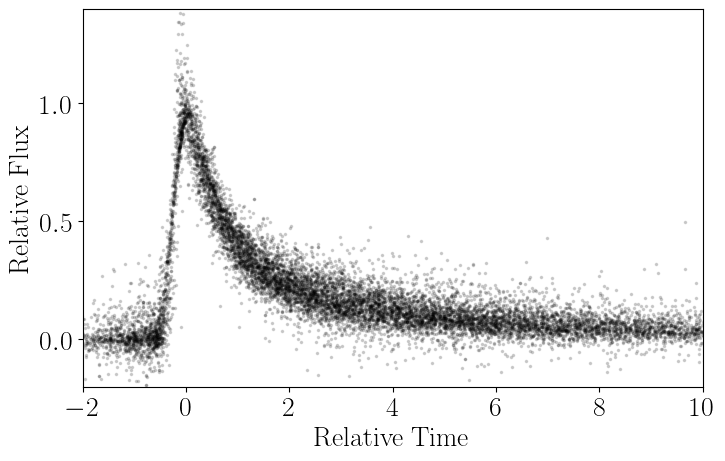

In [16]:
fit_time = fit_flare_vals['time'].values
fit_flux = fit_flare_vals['flux'].values
fit_flux_err = fit_flare_vals['flux_err'].values
fit_gp_err = fit_flare_vals['gp_st_dev'].values

fit_both_errors = np.sqrt( (fit_flux_err)**2 + (fit_gp_err)**2 )

fit_sort = np.argsort(fit_time)
plt.scatter(fit_time[fit_sort],fit_flux[fit_sort],alpha=.15,s=10,marker='.',color='k')
plt.ylim(-0.2,1.4)
plt.xlim(-2,10)
plt.xlabel("Relative Time")
plt.ylabel("Relative Flux")
#plt.savefig('/Users/lupitatovar/flares/figures/kepler_stacked_flares_final.png',bbox_inches='tight')

Flare diagnostics + Model Fits to each one of the classical flares in the Kepler sample

In [17]:
from scipy.optimize import least_squares,curve_fit, minimize

In [18]:
detrended = df['detrended_flux'].values - df['mean'].values
error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))

In [19]:
#coeffs = []
tpeaks = [] 
fwhms = [] 
amps = []

tpeaks_err = []
fwhms_err = []
amps_err = []
#t, tpeak, fwhm, ampl
for i in range (0,len(final_kepler)):

    #taking care of nan_arrays

    t_nan_array = np.isnan(fit_time[fit_sort])
    t_not_nan_array = ~ t_nan_array
    no_nan_time = fit_time[t_not_nan_array]

    no_infs = np.isfinite(no_nan_time)

    #Defining times of each flare event
    i_temp2 = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]
    
    peak_flujo = final_kepler['t_stop'].values-final_kepler['t_start'].values
    # arrays to feed into curvefit
    #x_to_fit = no_nan_time[no_infs]
    #y_to_fit = flux[t_not_nan_array][no_infs]
    
    x_fit = df['time'].values[i_temp2]
    y_fit = detrended[i_temp2]


    #defining the error array to feed into curvefit
    #error1 = np.sqrt( (((df['df_flux_err'].values)**2)) + (((df['std'].values)**2)))
    

    #print(error1)
    init_vals= [final_kepler['t_peak'].values[i],peak_flujo[i]/4,final_kepler['flux peak'].values[i]]

    best_vals, covar = curve_fit(kepler_model,x_fit,y_fit, p0=init_vals, maxfev=10000, sigma = error1[i_temp2],
                                  bounds=[[min(x_fit),0,0],[max(x_fit),peak_flujo[i],3*max(y_fit)]])
    
    #absolute_sigma = True
    #print('best_vals: {}'.format(best_vals))
    
    err = np.sqrt(np.diag(covar))
    ############# Saving Output Arrays ################
    tpeaks = np.append(tpeaks,best_vals[0])
    fwhms = np.append(fwhms,best_vals[1])
    amps = np.append(amps,best_vals[2])
    
    tpeaks_err = np.append(tpeaks_err,err[0])
    fwhms_err = np.append(fwhms_err,err[1])
    amps_err = np.append(amps_err,err[2])


In [20]:
print(len(df['time'].values))
print(len(detrended))
print(len(tpeaks))

453111
453111
414


In [147]:
#modeled_flares = pd.DataFrame({'tpeaks':tpeaks, 'fwhms':fwhms, 'amps':amps,
                              #'tpeak_err':tpeaks_err,'fwhms_err':fwhms_err,'amps_err':amps_err})

In [149]:
#modeled_flares.to_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/flares_modeled.csv')

In [140]:
#plt.plot(tpeaks)

In [22]:
''''
for i in range(len(final_kepler)):
    plt.figure(figsize=[12,6])
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],kepler_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='model fit',lw=3)

    plt.plot(df['time'],detrended,color='black',label='flare',alpha=0.5)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    plt.axvline(x=final_kepler['t_start'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=final_kepler['t_stop'].values[i], color='green', linestyle='-',alpha=0.7)
    plt.axvline(x=tpeaks[i], color='purple', linestyle='-')
    

    plt.ylim(-.002,final_kepler['flux peak'].values[i]+.005)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    plt.xlim(final_kepler['t_start'].values[i]-.005*final_kepler['Flare_Duration'].values[i],final_kepler['t_stop'].values[i]+.005*final_kepler['Flare_Duration'].values[i])
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
    plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    plt.savefig('/Users/lupitatovar/local_flares/fit_flares/fits_404_flares'+'flare'+str(i)+'.png',bbox_inches='tight')
    plt.close()
    
'''

"'\nfor i in range(len(final_kepler)):\n    plt.figure(figsize=[12,6])\n    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] \n    \n    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)\n    i_temp = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & \n                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]\n    \n    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])\n    temp_y_stack = ((detrended[i_temp])/(amps[i]))\n    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')\n    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')\n    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')\n    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)\n\n    plt.plot(df['time'],kepler_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='model fit',lw=3)\n\n    plt.plot(df['time'],det

/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


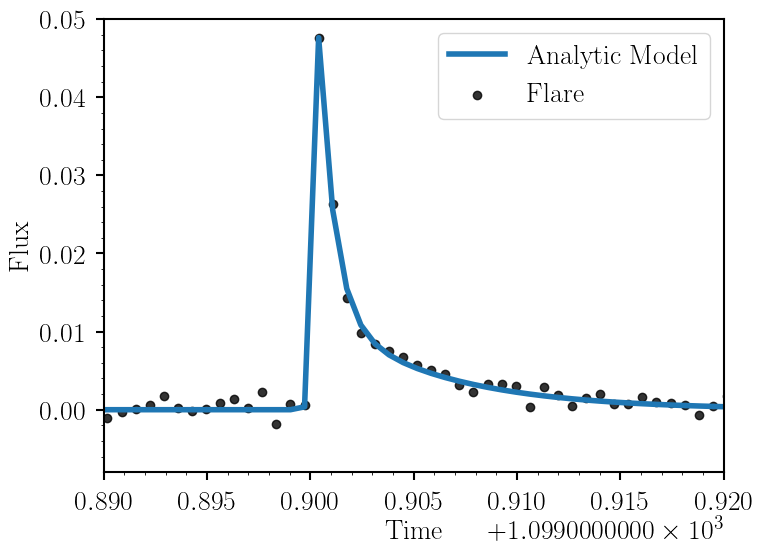

In [23]:
for i in range(1):#len(final_kepler)):
    i=224
    
    #105 has example of the drop off on the rise phase
    
    plt.figure(figsize=[8,6])
    plt.rcParams['axes.linewidth']=1.5
    plt.tick_params(direction='out',width=1.5,length=6,pad=7)
    plt.minorticks_on()
    
    
    #flux_fwhm = np.where(yinterp > half_peaks[i])[0] 
    
    #plt.scatter(tpeaks[i],amps[i],color='red',label='peak',s=50)
    i_temp = np.where((df['time'].values <= final_kepler['t_stop'].values[i]+0.01) & 
                    (df['time'].values >= final_kepler['t_start'].values[i]-0.005))[0]
    
    temp_x_stack = (df['time'].values[i_temp] - tpeaks[i])/(fwhms[i])
    temp_y_stack = ((detrended[i_temp])/(amps[i]))
    #plt.plot(temp_x_stack[i],temp_y_stack[i],color='black')
    #plt.plot(xvals,yinterp,color='black',alpha=0.8,label='interp_data')
    #plt.plot(np.where(xvals,np.where((yinterp > half_peaks[i]))[0],color='black',alpha=0.8,label='interp_data')
    #plt.scatter(xvals[flux_fwhm],yinterp[flux_fwhm], color='red', s=20,label='flux>fwhm',alpha=0.5)

    plt.plot(df['time'],kepler_model(df['time'],tpeaks[i],fwhms[i],amps[i]),color='C0',label='Analytic Model',lw=4)

    plt.scatter(df['time'],detrended,color='black',label='Flare',alpha=0.8)

    #plt.axhline(y=half_peaks[i], color='green', linestyle='-',label='t_half',alpha=0.7)
    #plt.axvline(x=final_kepler['t_start'].values[i], color='green', linestyle='-',alpha=0.7)
    #plt.axvline(x=final_kepler['t_stop'].values[i], color='green', linestyle='-',alpha=0.7)
    #plt.axvline(x=tpeaks[i], color='purple', linestyle='-')
    plt.annotate("",xy=(0.895+1.099e3,0.05), arrowprops=dict(arrowstyle="<->",color='k', lw=5))

    #plt.ylim(-.002,final_kepler['flux peak'].values[i]+.005)
    plt.xlim(-.11+1.1e3,0.92+1.099e3)
    plt.ylim(-0.008,0.05)
    #plt.xlim(timed_classical['t_start'].values[i]-.1,timed_classical['t_stop'].values[i]+.1)
    #plt.xlim(final_kepler['t_start'].values[i]-.005*final_kepler['Flare_Duration'].values[i],final_kepler['t_stop'].values[i]+.005*final_kepler['Flare_Duration'].values[i])
    plt.legend(loc='upper right')
    #plt.title('Flare:'+ str(i))
    plt.xlabel('Time')
    plt.ylabel('Flux')
    #plt.savefig('/Users/lupitatovar/local_flares/paper_figs/annotated_flare.png',bbox_inches='tight')
    #plt.close()

In [24]:
flare_vals = pd.read_csv('/Users/lupitatovar/local_flares/final_flare_lists/Kepler/flares_modeled.csv')

In [25]:
len(flare_vals)

414

### Plotting the Amplitude v FWHM

In [77]:
#plt.scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,c=durations)

Text(0, 0.5, 'Flare FWHM')

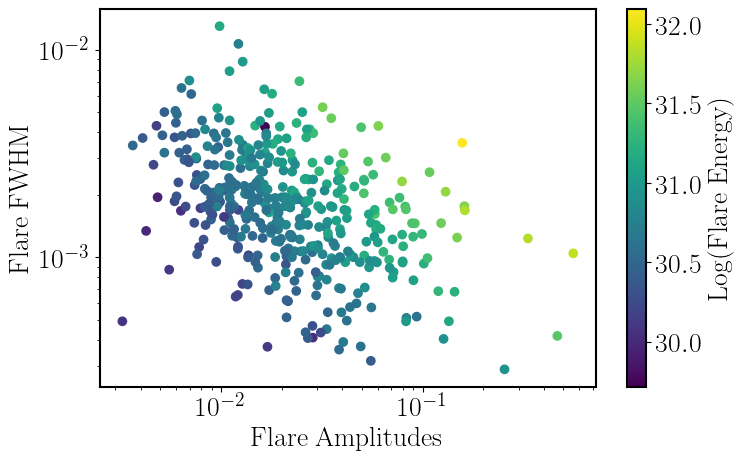

In [136]:

#plt.errorbar(flare_vals['amps'].values,flare_vals['fwhms'].values,xerr=flare_vals['amps_err'].values,yerr=flare_vals['fwhms_err'].values,
             #linestyle='none',marker='o')

scatter = plt.scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,marker='o',c=energy)

plt.xscale('log')
plt.yscale('log')
#plt.legend(handles=scatter.legend_elements()[0],title="Energies")
plt.colorbar(scatter, label='Log(Flare Energy)')

plt.xlabel('Flare Amplitudes')
plt.ylabel('Flare FWHM')

In [27]:
len(amps)

414

In [28]:
durations = final_kepler['t_stop'].values-final_kepler['t_start'].values
print(len(durations))

414


In [62]:
#durations #in days
durations_min = durations*1440
#print(durations_min)

### Plotting Amplitudes v Durations
Note that our sample uses classical flares with durations from 20-75 min to follow D14

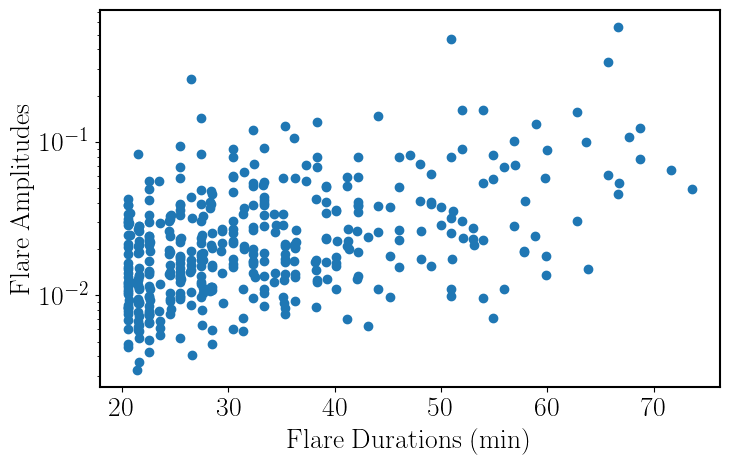

In [31]:
#make amplitude v duration plot HERE
plt.scatter(durations_min,flare_vals['amps'].values,marker='o')
plt.ylabel('Flare Amplitudes')
plt.xlabel('Flare Durations (min)')
#plt.xscale('log')
plt.yscale('log')

### Durations v Energy

In [61]:
#flare equivalent durations + luminosity
Lo= 30.037849 
energy = np.log10(final_kepler['ED'].values) + Lo
#print(energy)

Text(0, 0.5, 'log Flare Energy')

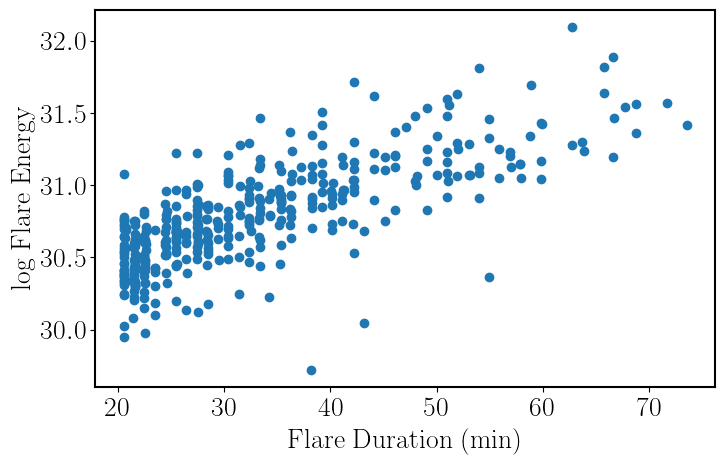

In [33]:
plt.scatter(durations_min,energy,marker='o')
plt.xlabel('Flare Duration (min)')
plt.ylabel('log Flare Energy')
#plt.xscale('log')
#plt.yscale('log')

In [143]:
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans - serif"
rcParams["font.sans-serif"] = ["Verdana"]
rcParams["text.usetex"] = True


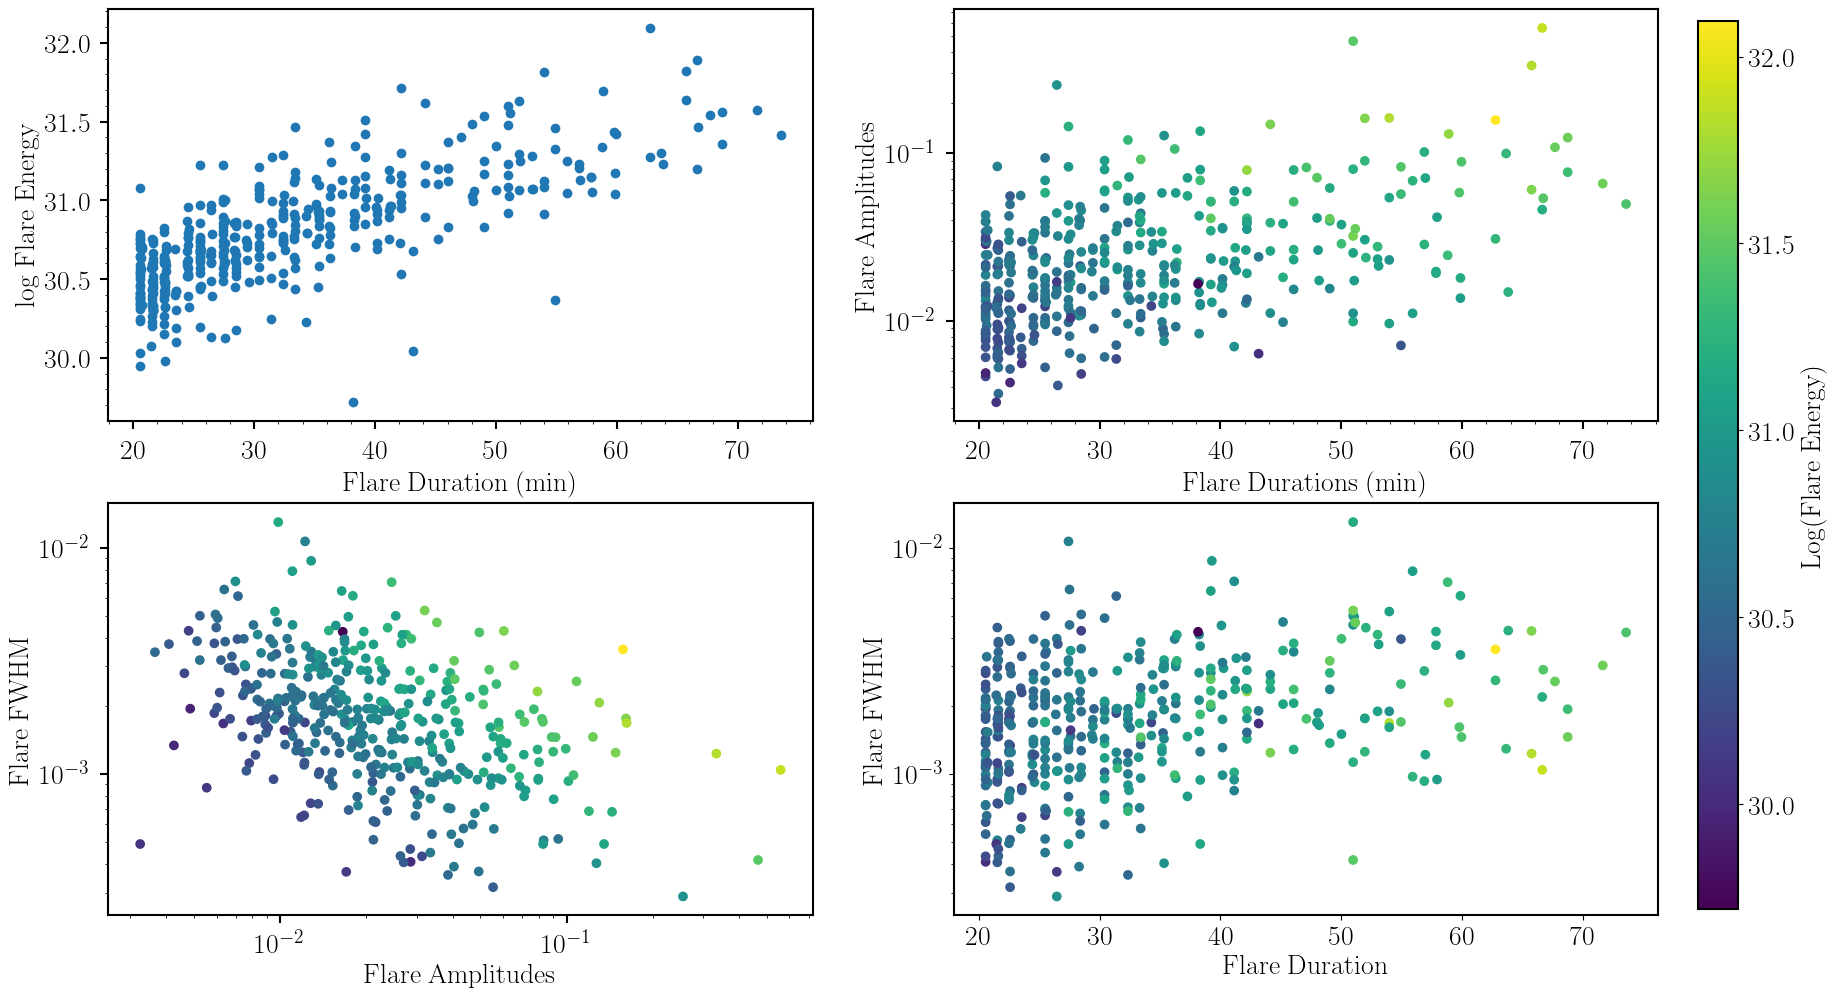

In [144]:
fig, axs = plt.subplots(2,2, figsize=(20, 12), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,0].minorticks_on()
axs[1,0].minorticks_on()
axs[0,1].minorticks_on() 

#Duration (min) v Energy
axs[0,0].scatter(durations_min,energy,marker='o')
axs[0,0].set_xlabel('Flare Duration (min)')
axs[0,0].set_ylabel('log Flare Energy')


#Duration (min) v Flare Amps
axs[0,1].scatter(durations_min,flare_vals['amps'].values,marker='o',c=energy)
axs[0,1].set_ylabel('Flare Amplitudes')
axs[0,1].set_xlabel('Flare Durations (min)')
axs[0,1].set_yscale('log')

### Flare amps v fwhms
#axs[1,0].errorbar(flare_vals['amps'].values,flare_vals['fwhms'].values,xerr=flare_vals['amps_err'].values,yerr=flare_vals['fwhms_err'].values,
             #linestyle='none',marker='o')
scatter = axs[1,0].scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,marker='o',c=energy)

#axs[1,0].set_colorbar(scatter, label='Log(Flare Energy)')


plt.xlabel('Flare Amplitudes')
plt.ylabel('Flare FWHM')

axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

#dur v fwhm
axs[1,1].scatter(durations_min,flare_vals['fwhms'].values,marker='o',c=energy)

#axs[1,0].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,0].set_xlabel('Flare Amplitudes')
axs[1,0].set_ylabel('Flare FWHM')

axs[1,1].set_xlabel('Flare Duration')
axs[1,1].set_ylabel('Flare FWHM')


#### Color map ####
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.74])
fig.colorbar(scatter, cax=cbar_ax,label='Log(Flare Energy)')
###### add in error bars where they exist #########

Energy Plots

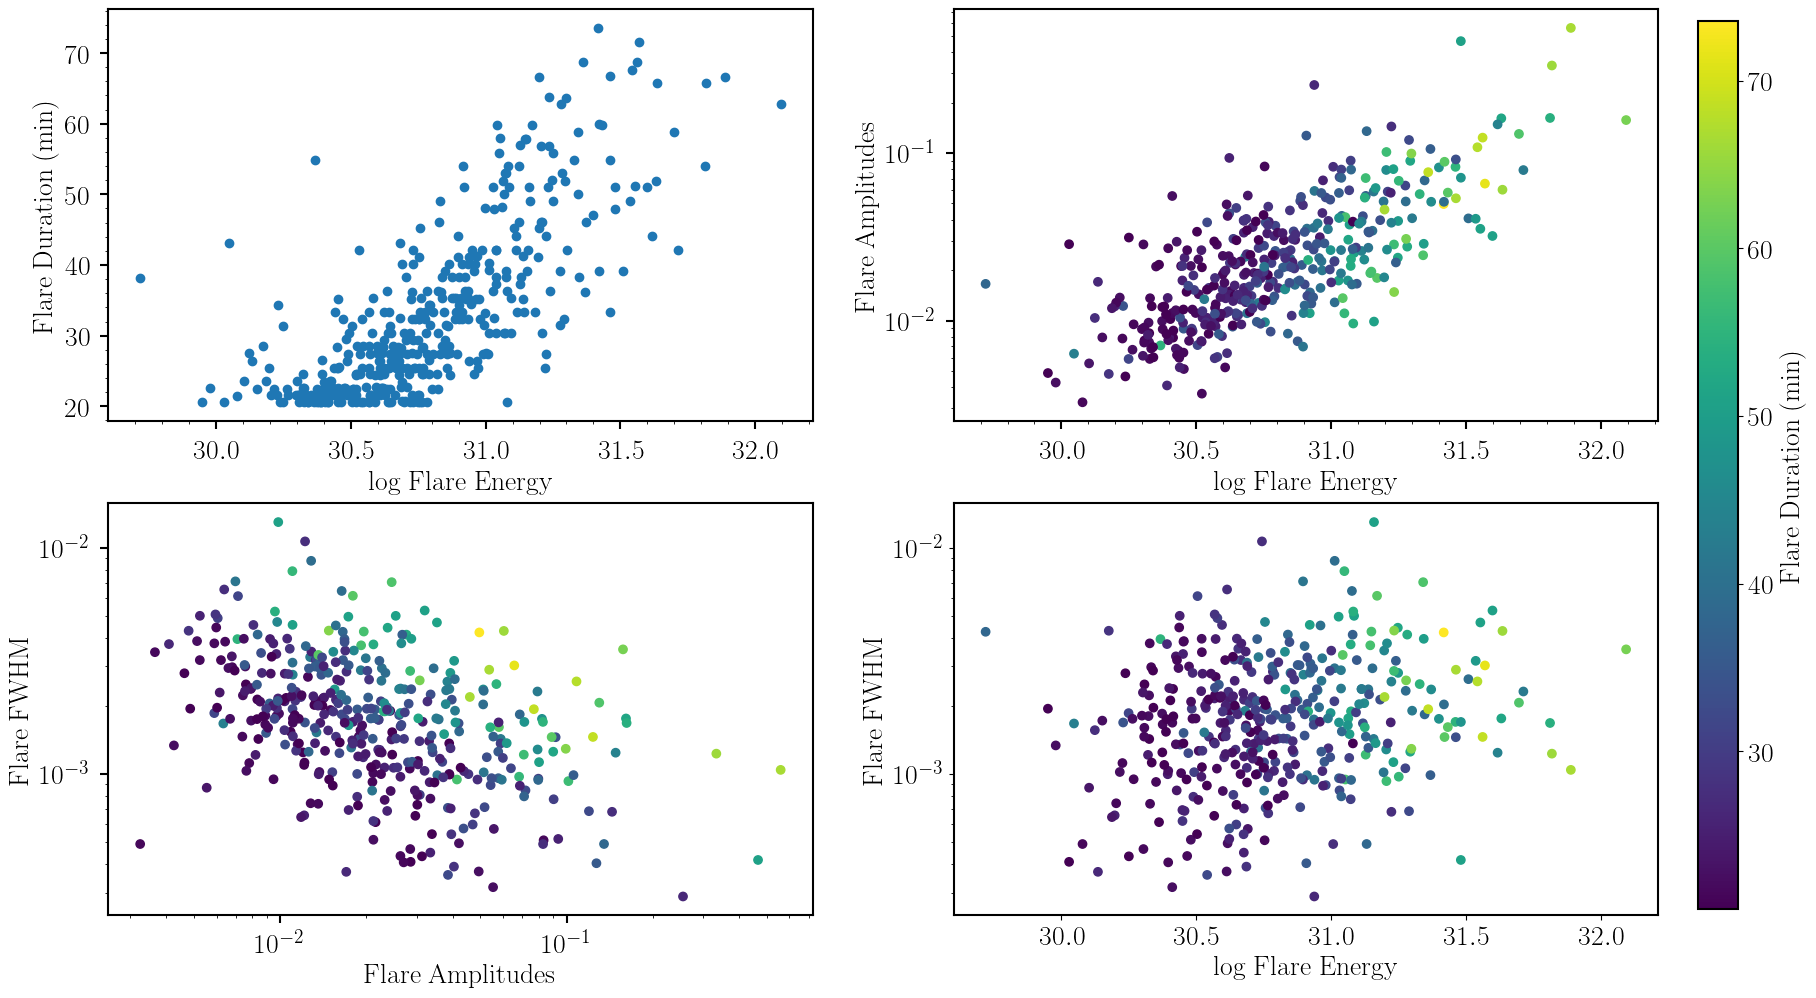

In [145]:
fig, axs = plt.subplots(2,2, figsize=(20, 12), facecolor='w', edgecolor='k')
plt.rcParams['axes.linewidth']=1.5
axs[0,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[1,0].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,1].tick_params(direction='out',width=1.5,length=6,pad=7)
axs[0,0].minorticks_on()
axs[1,0].minorticks_on()
axs[0,1].minorticks_on() 

#Energy v Duration
axs[0,0].scatter(energy,durations_min,marker='o')
axs[0,0].set_ylabel('Flare Duration (min)')
axs[0,0].set_xlabel('log Flare Energy')


#Energy v Flare Amps
axs[0,1].scatter(energy,flare_vals['amps'].values,marker='o',c=durations_min)
axs[0,1].set_ylabel('Flare Amplitudes')
axs[0,1].set_xlabel('log Flare Energy')
axs[0,1].set_yscale('log')

#Flare amps v fwhms
#axs[1,0].errorbar(flare_vals['amps'].values,flare_vals['fwhms'].values,xerr=flare_vals['amps_err'].values,yerr=flare_vals['fwhms_err'].values,
             #linestyle='none',marker='o')
scatter2 = axs[1,0].scatter(flare_vals['amps'].values,flare_vals['fwhms'].values,marker='o',c=durations_min)
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')

#energy v fwhm
axs[1,1].scatter(energy,flare_vals['fwhms'].values,marker='o',c=durations_min)
#axs[1,0].set_xscale('log')
axs[1,1].set_yscale('log')

axs[1,0].set_xlabel('Flare Amplitudes')
axs[1,0].set_ylabel('Flare FWHM')

axs[1,1].set_xlabel('log Flare Energy')
axs[1,1].set_ylabel('Flare FWHM')

#### Color map ####
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.13, 0.02, 0.74])
fig.colorbar(scatter2, cax=cbar_ax,label='Flare Duration (min)')


###### add in error bars where they exist #########

Flare Energy vs (amp*fwhm)

These should have a tight correlation! amp * fwhm measures the area of the flare (units of energy) which should correlate to overall flare energy

In [53]:
amp_fwhm = flare_vals['amps'].values * flare_vals['fwhms'].values
#print(amp_fwhm)

Text(0, 0.5, 'Log(amp*fwhm)')

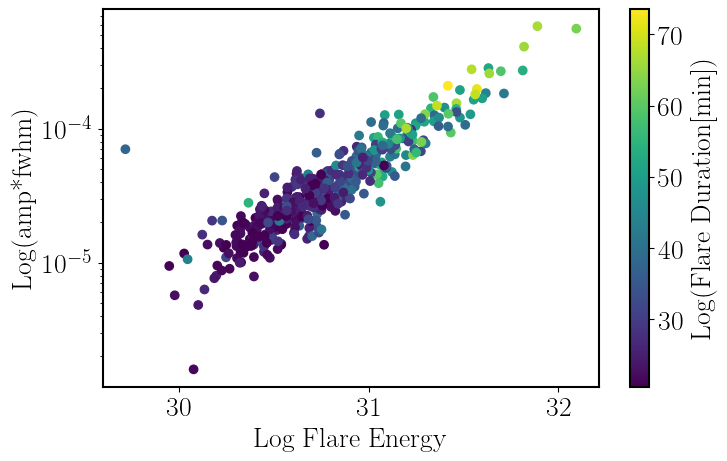

In [142]:
scatter3=plt.scatter(energy,amp_fwhm,c=durations_min)
plt.colorbar(scatter3, label='Log(Flare Duration[min])')
plt.yscale('log')
plt.xlabel('Log Flare Energy')
plt.ylabel('Log(amp*fwhm)')